In [1]:
import matplotlib.pyplot as plt

def read_evrp_file(file_path):
    data = {
        'COMMENT': '',
        'OPTIMAL_VALUE': 0,
        'VEHICLES': 0,
        'DIMENSION': 0,
        'STATIONS': 0,
        'CAPACITY': 0,
        'ENERGY_CAPACITY': 0,
        'ENERGY_CONSUMPTION': 0,
        'NODE_COORD_SECTION': {},
        'DEMAND_SECTION': {},
        'STATIONS_COORD_SECTION': [],
        'DEPOT_SECTION': None
    }
    
    current_section = None
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            
            # Check for section headers
            if line.startswith('COMMENT'):
                data['COMMENT'] = line.split(':', 1)[1].strip()
                current_section = None
            elif line.startswith('OPTIMAL_VALUE'):
                data['OPTIMAL_VALUE'] = float(line.split(':', 1)[1].strip())
                current_section = None
            elif line.startswith('VEHICLES'):
                data['VEHICLES'] = int(line.split(':', 1)[1].strip())
                current_section = None
            elif line.startswith('DIMENSION'):
                data['DIMENSION'] = int(line.split(':', 1)[1].strip())
                current_section = None
            elif line.startswith('STATIONS_COORD_SECTION'):
                current_section = 'STATIONS_COORD_SECTION'
            elif line.startswith('STATIONS'):
                data['STATIONS'] = int(line.split(':', 1)[1].strip())
                current_section = None
            elif line.startswith('CAPACITY'):
                data['CAPACITY'] = int(line.split(':', 1)[1].strip())
                current_section = None
            elif line.startswith('ENERGY_CAPACITY'):
                data['ENERGY_CAPACITY'] = float(line.split(':', 1)[1].strip())
                current_section = None
            elif line.startswith('ENERGY_CONSUMPTION'):
                data['ENERGY_CONSUMPTION'] = float(line.split(':', 1)[1].strip())
                current_section = None
            elif line.startswith('NODE_COORD_SECTION'):
                current_section = 'NODE_COORD_SECTION'
            elif line.startswith('DEMAND_SECTION'):
                current_section = 'DEMAND_SECTION'
            elif line.startswith('DEPOT_SECTION'):
                current_section = 'DEPOT_SECTION'
            elif line == 'EOF':
                break
            else:
                if current_section == 'NODE_COORD_SECTION':
                    parts = line.split()
                    node_id = int(parts[0])
                    x = float(parts[1])
                    y = float(parts[2])
                    data['NODE_COORD_SECTION'][node_id] = (x, y)
                elif current_section == 'DEMAND_SECTION':
                    parts = line.split()
                    node_id = int(parts[0])
                    demand = int(parts[1])
                    data['DEMAND_SECTION'][node_id] = demand
                elif current_section == 'STATIONS_COORD_SECTION':
                    if line.strip() and line != '-1':
                        station_id = int(line.strip())
                        data['STATIONS_COORD_SECTION'].append(station_id)
                elif current_section == 'DEPOT_SECTION':
                    if line.strip() != '-1':
                        data['DEPOT_SECTION'] = int(line.strip())
    
    return data

In [2]:
def plot_evrp_instance(data):
    # Extract coordinates
    coords = data['NODE_COORD_SECTION']
    depot_id = data['DEPOT_SECTION']
    station_ids = data['STATIONS_COORD_SECTION']
    
    # Separate customers, depot, and stations
    customer_ids = [node_id for node_id in coords.keys() 
                   if node_id != depot_id and node_id not in station_ids]
    
    # Plotting
    plt.figure(figsize=(10, 8))
    
    # Plot customers
    customer_x = [coords[node_id][0] for node_id in customer_ids]
    customer_y = [coords[node_id][1] for node_id in customer_ids]
    plt.scatter(customer_x, customer_y, c='blue', label='Customers', s=50)
    
    # Plot depot
    depot_x, depot_y = coords[depot_id]
    plt.scatter(depot_x, depot_y, c='red', label='Depot', s=100, marker='s')
    
    # Plot stations
    station_x = [coords[node_id][0] for node_id in station_ids]
    station_y = [coords[node_id][1] for node_id in station_ids]
    plt.scatter(station_x, station_y, c='green', label='Stations', s=75, marker='^')
    
    # Annotate node IDs
    for node_id, (x, y) in coords.items():
        plt.annotate(str(node_id), (x, y), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.title('EVRP Instance Visualization')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import random

def plot_single_route_with_trips(data, single_route):
    """
    Plota uma única rota com múltiplos trajetos separados por depósitos (1).
    Cada segmento entre dois '1's é considerado um trajeto diferente.
    
    Parâmetros:
    - data: dicionário com os dados do problema
    - single_route: lista contendo uma única rota com múltiplos trajetos (ex: [1,2,3,1,4,5,1])
    """
    # Extrai coordenadas
    coords = data['NODE_COORD_SECTION']
    depot_id = data['DEPOT_SECTION']
    station_ids = data['STATIONS_COORD_SECTION']
    
    # Divide a rota única em trajetos separados
    trips = []
    current_trip = []
    
    for node in single_route:
        if node == 1 and current_trip:
            current_trip.append(1)  # Fecha o trajeto
            trips.append(current_trip)
            current_trip = [1]  # Começa novo trajeto
        else:
            current_trip.append(node)
    
    # Adiciona o último trajeto se necessário
    if len(current_trip) > 1:
        current_trip.append(1)
        trips.append(current_trip)
    
    # Separa clientes visitados/não visitados
    all_customers = [node_id for node_id in coords.keys() 
                    if node_id != depot_id and node_id not in station_ids]
    visited_customers = [node for trip in trips for node in trip[1:-1]]
    unvisited_customers = list(set(all_customers) - set(visited_customers))
    
    # Configuração do plot
    plt.figure(figsize=(12, 8))
    
    # Plot de clientes não visitados (cinza)
    unvisited_x = [coords[node_id][0] for node_id in unvisited_customers]
    unvisited_y = [coords[node_id][1] for node_id in unvisited_customers]
    plt.scatter(unvisited_x, unvisited_y, c='gray', label='Unvisited customers', s=50, alpha=0.5)
    
    # Plot de estações (verde)
    station_x = [coords[node_id][0] for node_id in station_ids]
    station_y = [coords[node_id][1] for node_id in station_ids]
    plt.scatter(station_x, station_y, c='green', label='Stations', s=75, marker='^', alpha=0.7)
    
    # Plot do depósito (vermelho)
    depot_x, depot_y = coords[depot_id]
    plt.scatter(depot_x, depot_y, c='red', label='Depot', s=150, marker='s')
    
    # Cores para os trajetos
    colors = plt.cm.tab10.colors
    
    # Plot cada trajeto com cor diferente
    for i, trip in enumerate(trips):
        color = colors[i % len(colors)]
        trip_x = [coords[node_id][0] for node_id in trip]
        trip_y = [coords[node_id][1] for node_id in trip]
        
        # Linha do trajeto
        plt.plot(trip_x, trip_y, 'o-', color=color, linewidth=2, markersize=8,
                label=f'Trip {i+1}')
        
        # Setas para direção
        for j in range(len(trip)-1):
            plt.annotate('', xy=(trip_x[j+1], trip_y[j+1]), xytext=(trip_x[j], trip_y[j]),
                        arrowprops=dict(arrowstyle='->', color=color, lw=1.5))
    
    # Anotações dos IDs
    for node_id, (x, y) in coords.items():
        plt.annotate(str(node_id), (x, y), textcoords="offset points", 
                    xytext=(0,5), ha='center', fontsize=8)
    
    plt.title(f'EVRP Route Visualization\nTotal Trips: {len(trips)}', fontsize=14)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
import random
import numpy as np

def gerar_rota_unica_com_multiplas_viagens(num_clientes, num_rotas=3):
    """
    Gera uma única rota que representa múltiplas viagens de caminhões.
    Formato: [1, clientes..., 1, clientes..., 1, ..., 1]
    Regras:
    - Sempre começa e termina com 1
    - Contém exatamente (num_rotas - 1) '1's no meio
    - Nenhum '1' consecutivo
    """
    if num_rotas < 2:
        raise ValueError("num_rotas deve ser pelo menos 2")
    
    clientes = list(range(2, 2 + num_clientes))  # IDs dos clientes
    random.shuffle(clientes)
    
    # Divide os clientes em (num_rotas) grupos
    divisoes = sorted(random.sample(range(1, num_clientes), k=num_rotas-1))
    grupos = []
    inicio = 0
    for fim in divisoes:
        grupos.append(clientes[inicio:fim])
        inicio = fim
    grupos.append(clientes[inicio:])  # Último grupo
    
    # Constroi a rota única intercalando com depósitos
    rota = [1]
    for grupo in grupos:
        rota.extend(grupo)
        rota.append(1)
    
    # Garante que não sobrou nenhum cliente
    assert len([x for x in rota if x != 1]) == num_clientes
    
    return np.array(rota)

gerar_rota_unica_com_multiplas_viagens(22)

array([ 1, 10,  9,  6,  5, 18,  2, 22, 20,  4, 11, 19, 14, 21,  8,  1, 13,
        7, 23, 12, 16, 17,  1,  3, 15,  1])

In [5]:
import math

def calcular_distancia_total(data, rota):
    """
    Calcula a distância total percorrida em uma rota com múltiplos trajetos.
    
    Parâmetros:
    - data: dicionário contendo 'NODE_COORD_SECTION' com as coordenadas dos nós
    - rota: lista representando a rota completa com múltiplos trajetos (ex: [1,2,3,1,4,5,1])
    
    Retorna:
    - Distância total percorrida
    """
    coords = data['NODE_COORD_SECTION']
    distancia_total = 0.0
    
    for i in range(len(rota) - 1):
        node_atual = rota[i]
        node_proximo = rota[i+1]
        
        x1, y1 = coords[node_atual]
        x2, y2 = coords[node_proximo]
        
        distancia_total += math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return distancia_total

In [14]:
def codifica_rota(rota):
    resultado = []
    for num in rota:
        # Garante que o número está no intervalo [0, 31]
        num_truncado = max(0, min(num, 31))
        # Converte para binário de 5 bits e preenche com zeros à esquerda
        binario = format(num_truncado, '05b')
        # Separa cada bit e converte para inteiro
        bits_separados = [int(bit) for bit in binario]
        # Adiciona ao resultado
        resultado.extend(bits_separados)
    return np.array(resultado)

In [15]:
def decodifica_rota(rota):
    # Converte para lista se for numpy array
    bits_list = list(rota) if isinstance(rota, np.ndarray) else rota
    
    # Verifica se o comprimento é múltiplo de 5
    if len(bits_list) % 5 != 0:
        raise ValueError("O array de bits deve ter comprimento múltiplo de 5")
    
    resultado = []
    for i in range(0, len(bits_list), 5):
        # Pega os próximos 5 bits
        cinco_bits = bits_list[i:i+5]
        # Converte para string binária
        bin_str = ''.join(map(str, cinco_bits))
        # Converte para inteiro
        numero = int(bin_str, 2)
        resultado.append(numero)
    
    return np.array(resultado)

# Testes

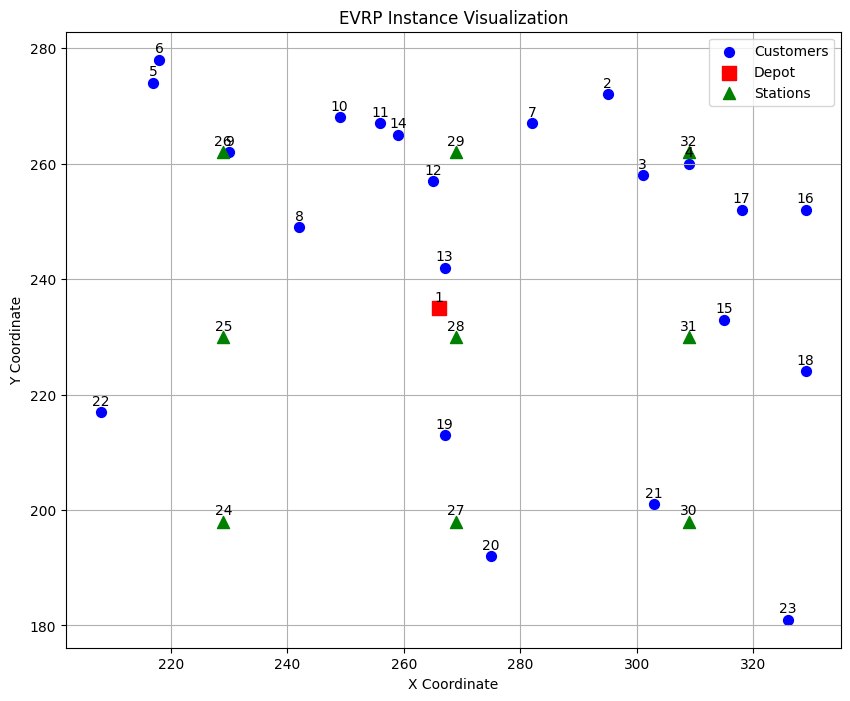

Depot: 1
Stations: [24, 25, 26, 27, 28, 29, 30, 31, 32]
Number of customers: 22


In [8]:
file_path = 'E-n23-k3.evrp'  # Change this to your file path
evrp_data = read_evrp_file(file_path)
plot_evrp_instance(evrp_data)

# Print some data for verification
print("Depot:", evrp_data['DEPOT_SECTION'])
print("Stations:", evrp_data['STATIONS_COORD_SECTION'])
print("Number of customers:", len(evrp_data['NODE_COORD_SECTION']) - 1 - len(evrp_data['STATIONS_COORD_SECTION']))

In [19]:
rota_ex = [1,11,14,1,13,12,10,9,6,5,22,8,1,19,20,21,23,18,15,16,17,4,3,2,7,1]


Rota Atual: [ 1 22 23 16  2 19  4 21 10 17  3  1  9  6  5  1 14  8 15  7 20 18 12 11
 13  1]
Rota codificada: [0 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0
 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0
 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0
 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1]
Rota decodificada: [ 1 22 23 16  2 19  4 21 10 17  3  1  9  6  5  1 14  8 15  7 20 18 12 11
 13  1]
Igual?: True
Distância total percorrida: 1265.00


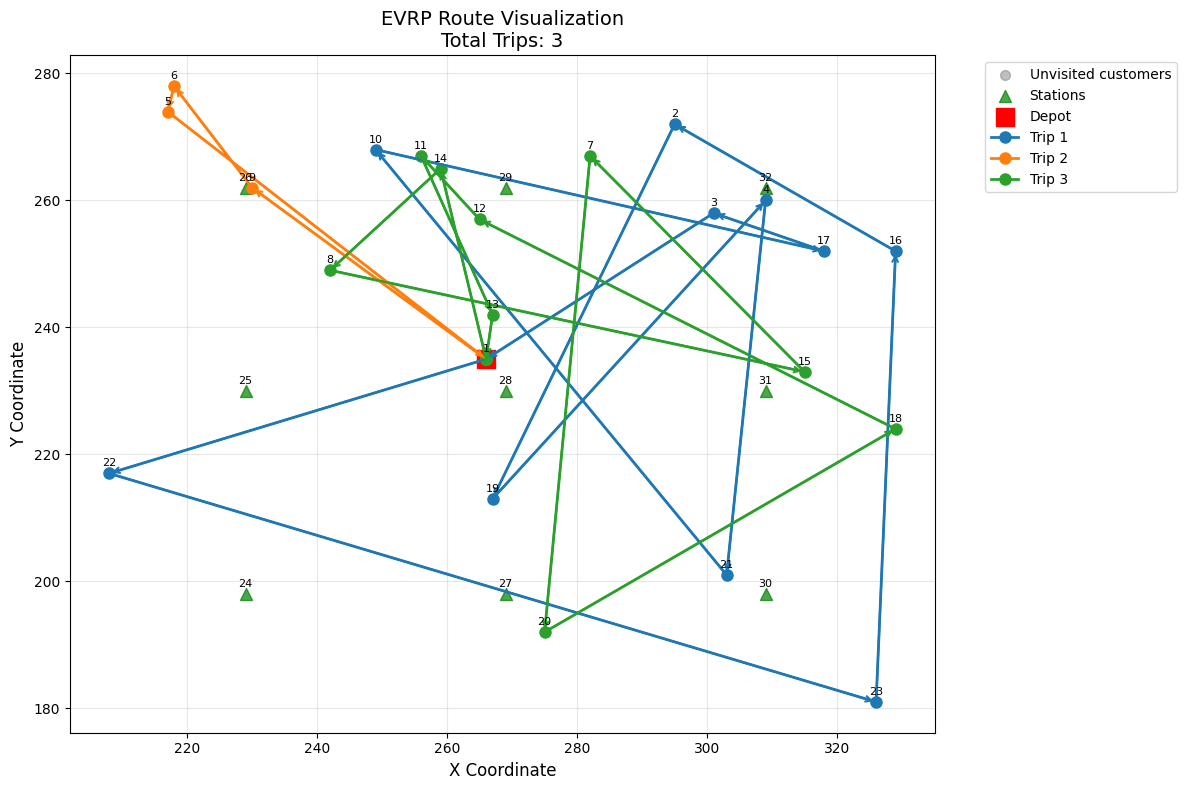

In [22]:
rota = gerar_rota_unica_com_multiplas_viagens(22)
cod = codifica_rota(rota)
dec = decodifica_rota(cod)

print(f"Rota Atual: {rota}")
print(f"Rota codificada: {cod}")
print(f"Rota decodificada: {dec}")
print(f"Igual?: {np.array_equal(rota, dec)}")

distancia = calcular_distancia_total(evrp_data, rota)
print(f"Distância total percorrida: {distancia:.2f}")
plot_single_route_with_trips(evrp_data, rota)